## Set UP

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)
%pip install wbdata
import wbdata
%pip install cufflinks
import cufflinks as cf
cf.go_offline()


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Set Population Source

In [2]:
#wbdata.get_source() to get all sources
#wbdata.get_topic()
#wbdata.get_indicator()

source_id = 40 #Population Estimates and Projections
indicators = wbdata.get_indicator(source=source_id)

## Search Place Code
The following is the example to search the place code for 'world'.

In [3]:
###change the term 'world' in the function to search the code for the place/region/country that you are interested in
wbdata.search_countries("world")

id    name
----  ----------
ARB   Arab World
WLD   World

# Deliverables

## 1. [A] Population Dataframes
A function that returns a pandas DataFrame indexed by Region or Country and Year, with columns giving counts of people in different age-sex groups.


#### Variables Clarification

population_df(year, sex, age_range, place_code):
<br>
year: 1960 to 2050 (projections)
<br>
sex: "male"/ "female"/ "all"
<br>
age_range: accepts a list of two integers which should be or will be rounded to nearest multiplers of 5; and includes first rounded integer but exludes the second 
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(ex. [0, 8] aging from 0 inclusive to 10 exclusive)
<br>
place_code: accepts country/region/place code


In [4]:
"""
population age ranges available from dataset:
00-04, 05-09, 10-14, 15-19, 20-24, 25-29, 30-34, ..., 70-74, 75-79, above 80
"""

def population_df(year=2000, sex='all', age_range=[0, 80], place_code='WLD'):
    ##get all five-year age groups from rounded age_range 
    age_ranges=age_list(age_range)
    male_variables = {"SP.POP."+i+".MA":"{}-{}".format(i[:2], i[2:]) for i in age_ranges}
    female_variables = {"SP.POP."+i+".FE":"{}-{}".format(i[:2], i[2:]) for i in age_ranges}
    male_population = get_population_data(year, male_variables, 'male', place_code)
    female_population = get_population_data(year, female_variables, 'female', place_code)
    if sex=='male':
        df=male_population
    elif sex=='female':
        df=female_population
    else:  
        df=male_population.merge(female_population, on="age").set_axis(male_population.index)
        total_pop = df["female"] + df["male"]
        df["total"] = total_pop
    return df


def get_population_data(year, variables, gender, place_code):
    population_data = wbdata.get_dataframe(variables, country=place_code)
    population_data.index = population_data.index.astype(int)
    population_data.reset_index(inplace=True)
    population_data = population_data[population_data['date']==year].melt(id_vars=["date"], var_name="age", value_name=gender)
    population_data['place'] = place_code
    population_data.set_index(['place', 'date'], inplace=True)
    return population_data



##age_list function returns a list of five-year age group strings from rounded age_range       
def age_list(age_range):
    #round age_range to nearst multiples of five 
    def round_age(age_range):
        for i in range(0,2):
            if 0<age_range[i]%5<3:
                age_range[i]-=age_range[i]%5
                i+=1
            elif age_range[i]%5>=3:
                age_range[i]+=(5-age_range[i]%5)
                i+=1
            else:
                i+=1
        return age_range
    results = []
    age_lb, age_ub = round_age(age_range) 
    while age_lb < min(79, age_ub):
        results.append("{:02d}{:02d}".format(age_lb, age_lb + 4))
        age_lb += 5
    if age_lb >= 80:
        results.append('80UP')
    return results   

In [5]:
population_df = population_df(year=2000, sex='all', age_range=[0, 80], place_code='WLD')
population_df

age         male       female        total
place date                                              
WLD   2000  00-04  319947454.0  299176185.0  619123639.0
      2000  05-09  317085952.0  297917803.0  615003755.0
      2000  10-14  319870427.0  302850456.0  622720883.0
      2000  15-19  293445532.0  280015254.0  573460786.0
      2000  20-24  263094592.0  252662959.0  515757551.0
      2000  25-29  256458181.0  248149260.0  504607441.0
      2000  30-34  241585037.0  235168152.0  476753189.0
      2000  35-39  216703667.0  212545788.0  429249455.0
      2000  40-44  187436101.0  185210979.0  372647080.0
      2000  45-49  166501073.0  166483260.0  332984333.0
      2000  50-54  131738554.0  133190888.0  264929442.0
      2000  55-59  102296144.0  105259506.0  207555650.0
      2000  60-64   90035292.0   96389771.0  186425063.0
      2000  65-69   71463003.0   80630658.0  152093661.0
      2000  70-74   53316050.0   65710609.0  119026659.0
      2000  75-79   32840343.0   47015814.0   79856157.0
      2000  80-UP   25022711.0   47104089.0   72126800.0

## 2. [A] Population Statistics
A python function named population that will deliver information to answer the queries of the following form:

In [year] how many [people/males/females] aged [low] to [high] were living in [the world/region/country]? 

The function population_stats(year, population, age_low, age_high, place_code) returns a population count given a year, sort of person, age range, and place.

Note:Input age_low (inclusive) and age_hig (exclusive) should be the multiplers of 5. Otherwise, it will automatically rounded to nearest multiplers of 5 by the following function.

In [6]:
def population_stats(year=2000, population='people', age_low=0, age_high=100, place_code='WLD'):
    if population == 'people':
        df= population_df(year=year, sex='all', age_range=[age_low, age_high], place_code=place_code)
        result=df['total'].sum()
    elif population == 'males':
        df=population_df(year, sex='male', age_range=[age_low, age_high], place_code=place_code)
        result=df['male'].sum()
    else:        
        df=population_df(year, sex='female', age_range=[age_low, age_high], place_code=place_code)
        result=df['female'].sum() 
    print(f"In {year}, there were {result} {population} aged from {age_low} to {age_high} living in {place_code}.")

In [7]:
population_stats(year=2000, population='people', age_low=0, age_high=100, place_code='WLD')

TypeError: 'WBDataFrame' object is not callable

# South Korea Data

[B] Population Pyramids

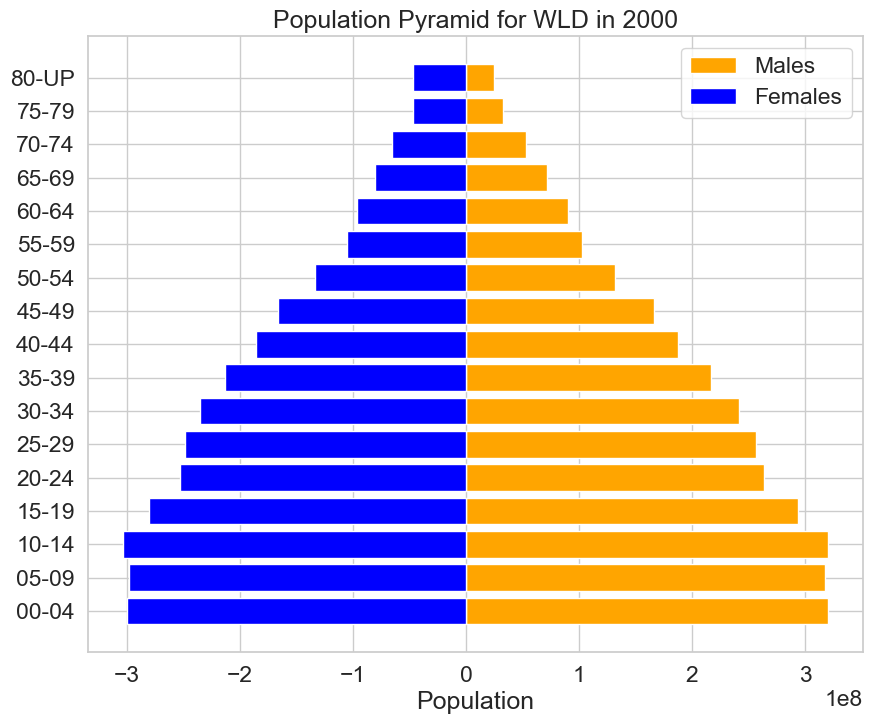

In [15]:
import matplotlib.pyplot as plt

def plot_population_pyramid(df, place, date):
    
    df_filtered = df.xs((place, date), level=('place', 'date'))
    
    df_filtered = df_filtered.sort_index()

    # Creating the bar plot
    age_groups = df_filtered['age']
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(age_groups, df_filtered['male'], color='orange', label='Males')
    ax.barh(age_groups, -df_filtered['female'], color='blue', label='Females')
    ax.set_xlabel('Population')
    ax.set_title(f'Population Pyramid for {place} in {date}')
    ax.legend()
    ax.grid(True)
    plt.show()

plot_population_pyramid(population_df, 'WLD', 2000)

 [C] Animated Population Pyramids

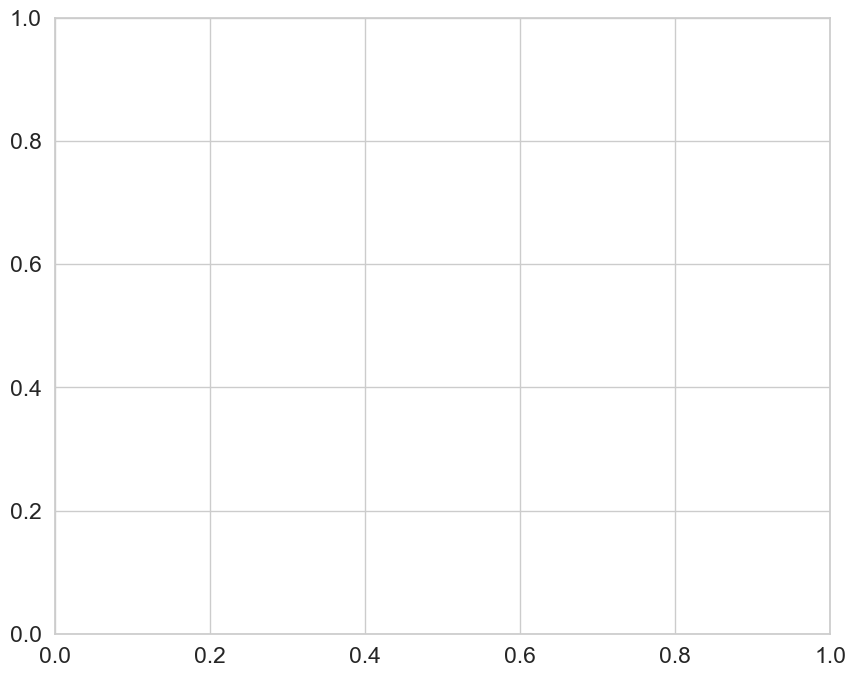

In [14]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate_population_pyramid(df, place, years):

    fig, ax = plt.subplots(figsize=(10, 8))
    
    def update(year):
        ax.clear()
        data_year = df.xs((place, year), level=('place', 'date'))
        age_groups = data_year['age']
        ax.barh(age_groups, data_year['male'], color='blue', label='Males')
        ax.barh(age_groups, -data_year['female'], color='pink', label='Females')
        ax.set_xlabel('Population')
        ax.set_title(f'Population Pyramid for {place} in {year}')
        ax.legend()
        ax.grid(True)
    
    anim = FuncAnimation(fig, update, frames=years, repeat=False)
    plt.show()

    return anim

# Usage example:
# Assuming your DataFrame is named df_population and 'WLD' is the place you want to animate
years_list = sorted(population_df.xs('WLD', level='place').index.get_level_values('date').unique())
animate_population_pyramid(population_df, 'WLD', years=years_list)
